# Movie Creation Analysis

Authors: Matt Silver, Brian Woo

## Overview

This project involves data cleaning, imputations, analysis, and visualizations to generate insights for a business stakeholder. The goal is to determine the most successful film genres currently dominating the box office, providing actionable insights for your company's new movie studio.

## Business Problem

### A leap into films
**Goal:**
- Our client is looking at an opportunity to diversify their business by exploring the film industry. In particular they are interested in creating original video content. They have created a new movie studio, but they don't know anything about creating movies. Our jobs as data scientists is to dive deep into the types of films that are currently doing the best at the box office, and take those findings and translating them into actionable insights that the CEO of our company could use to help determine which types of films are the most beneficial to create.

**Priorities:**
1. Ratings
    - The best rated films are usually the best films out there
2. Box Office Performance
    - Analyze the total grosses for each category
3. Profits
    - Compare the gross and the production budget to find out how much each of the film would profit
4. Year of Release
    - Determine if the a specific type of genre is increasing in popularity
5. Production Studios
    - Filter out the best production studios to pair with so they can find all of the proper casting and team for the film

### Souces of Data

- Box Office Mojo
- IMDB
- TheMovieDB
- The Numbers

## Extracting datasets

In [2308]:
# imports for extracting data
import os
import gzip
import shutil
import zipfile

# imports for data manipulation
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats as stats

# import for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2309]:
# extracting gz file to a folder called extractedData
source_directory = 'zippedData'
destination_directory = 'extractedData'

# Ensure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# List all .gz files in the source directory
gz_files = [f for f in os.listdir(source_directory) if f.endswith('.gz')]

# Loop through each .gz file and extract it
for gz_file in gz_files:
    gz_file_path = os.path.join(source_directory, gz_file)
    decompressed_file_path = os.path.join(destination_directory, os.path.splitext(gz_file)[0])

    # Open the .gz file and write the decompressed data to the destination directory
    with gzip.open(gz_file_path, 'rb') as f_in:
        with open(decompressed_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [2310]:
# extracting the zip file to a folder called extractedData
extract_to_directory = 'extractedData'  

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to_directory, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile('zippedData/im.db.zip'  , 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

## Understanding the Data

In [2311]:
# reading the csv files into dataframes
box_office_mojo_df = pd.read_csv('extractedData/bom.movie_gross.csv')
movie_db_df = pd.read_csv('extractedData/tmdb.movies.csv')
numbers_df = pd.read_csv('extractedData/tn.movie_budgets.csv')

# reading the db file into dataframes
conn = sqlite3.connect('extractedData/im.db')
imdb_columns_df = pd.read_sql(
    """
    SELECT *
    FROM sqlite_master
    """, conn)

# join the movie_ratings, movie_basics, and movie_akas tables
imdb_movies_df = pd.read_sql(
    """
    SELECT basics.primary_title, basics.start_year, basics.runtime_minutes, rating.averagerating as average_rating, rating.numvotes as num_votes, basics.genres
    FROM movie_ratings as rating
    JOIN movie_basics as basics
    USING (movie_id)
    JOIN movie_akas as akas
    USING (movie_id)
    WHERE basics.start_year >= 2000 AND akas.region = 'US'
    """, conn)

# join the principals and persons tables
imdb_people_df = pd.read_sql(
    """
    SELECT persons.primary_name, persons.birth_year, persons.death_year, principals.category, persons.primary_profession
    FROM principals
    JOIN persons
    USING (person_id)
    """, conn)

# close the connection
conn.close()

In [2312]:
box_office_mojo_df

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [2313]:
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [2314]:
box_office_mojo_df.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [2315]:
box_office_mojo_df.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [2316]:
movie_db_df

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [2317]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [2318]:
movie_db_df.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [2319]:
movie_db_df.describe()

,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [2320]:
numbers_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [2321]:
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [2322]:
numbers_df.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [2323]:
numbers_df.describe()

,id
count,5782.000000
mean,50.372363
std,28.821076
min,1.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,100.000000


In [2324]:
imdb_columns_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [2325]:
imdb_movies_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
1,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
2,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
3,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
4,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...
30189,Girl/Girl Scene,2019,122.0,2.1,112,"Comedy,Drama,Romance"
30190,Coconut the Little Dragon 2 Into the Jungle,2018,NaN,5.9,43,"Adventure,Animation,Comedy"
30191,Coconut the Little Dragon 2 Into the Jungle,2018,NaN,5.9,43,"Adventure,Animation,Comedy"
30192,Hail Satan?,2019,95.0,6.8,628,Documentary


In [2326]:
imdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30194 entries, 0 to 30193
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    30194 non-null  object 
 1   start_year       30194 non-null  int64  
 2   runtime_minutes  28075 non-null  float64
 3   average_rating   30194 non-null  float64
 4   num_votes        30194 non-null  int64  
 5   genres           30058 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 1.4+ MB


In [2327]:
imdb_movies_df.isna().sum()

primary_title         0
start_year            0
runtime_minutes    2119
average_rating        0
num_votes             0
genres              136
dtype: int64

In [2328]:
imdb_movies_df.describe()

,start_year,runtime_minutes,average_rating,num_votes
count,30194.000000,28075.000000,30194.000000,3.019400e+04
mean,2013.988375,93.308353,6.218606,1.387553e+04
std,2.584593,307.113224,1.578104,7.107716e+04
min,2010.000000,3.000000,1.000000,5.000000e+00
25%,2012.000000,81.000000,5.200000,1.700000e+01
50%,2014.000000,90.000000,6.400000,8.200000e+01
75%,2016.000000,100.000000,7.400000,7.420000e+02
max,2019.000000,51420.000000,10.000000,1.841066e+06


In [2329]:
imdb_people_df

,primary_name,birth_year,death_year,category,primary_profession
0,Tommy Dysart,NaN,NaN,actor,actor
1,Frank Howson,1952.0,NaN,director,"actor,writer,producer"
2,Barry Porter-Robinson,NaN,NaN,producer,"producer,art_department"
3,Sean Barton,1944.0,NaN,editor,"editor,editorial_department,assistant_director"
4,Brittania Nicol,NaN,NaN,actress,"actress,soundtrack"
...,...,...,...,...,...
1027907,Kenneth Cranham,1944.0,NaN,actor,"actor,soundtrack"
1027908,Pearl Mackie,1987.0,NaN,self,actress
1027909,Guy Jones,NaN,NaN,director,director
1027910,Sabrina Mahfouz,NaN,NaN,writer,writer


In [2330]:
imdb_people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027912 entries, 0 to 1027911
Data columns (total 5 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   primary_name        1027912 non-null  object 
 1   birth_year          234048 non-null   float64
 2   death_year          11843 non-null    float64
 3   category            1027912 non-null  object 
 4   primary_profession  974266 non-null   object 
dtypes: float64(2), object(3)
memory usage: 39.2+ MB


In [2331]:
imdb_people_df.isna().sum()

primary_name                0
birth_year             793864
death_year            1016069
category                    0
primary_profession      53646
dtype: int64

In [2332]:
imdb_people_df.describe()

,birth_year,death_year
count,234048.000000,11843.00000
mean,1967.742617,1995.25247
std,22.099106,64.57055
min,1.000000,17.00000
25%,1959.000000,2004.00000
50%,1971.000000,2014.00000
75%,1980.000000,2017.00000
max,2014.000000,2019.00000


## Data Cleaning

### Box Office Mojo Clean

In [2333]:
# retrieving title, domestic_gross, and year columns
box_office_mojo_df = box_office_mojo_df[['title', 'studio', 'domestic_gross', 'year']]

# get the rows with year >= 2000
box_office_mojo_df = box_office_mojo_df[box_office_mojo_df['year'] >= 2000]

# resets the index
box_office_mojo_df.reset_index(drop=True, inplace=True)

# sanity check
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 106.0+ KB


In [2334]:
# drops rows with missing values in the studio column
box_office_mojo_df.dropna(subset=['studio'], inplace=True)

In [2335]:
# find the duplicates
box_office_mojo_df[box_office_mojo_df.duplicated()]

,title,studio,domestic_gross,year


In [2336]:
# find unknown values in all columns
columns = ['title', 'studio', 'domestic_gross', 'year']
for column in columns:
    print(f'Unknown values in {column}: {len(box_office_mojo_df[box_office_mojo_df[column] == "Unknown"])}')

Unknown values in title: 1
Unknown values in studio: 0
Unknown values in domestic_gross: 0
Unknown values in year: 0


In [2337]:
# drop the row with unknown values in the title column
box_office_mojo_df.drop(box_office_mojo_df[box_office_mojo_df['title'] == "Unknown"].index, inplace=True)

Dropped the "Unknown" value in title because there is only 1 value missing in the entire dataset, and dropping it wouldn't affect the dataset greatly

In [2338]:
# find the rows with missing values
box_office_mojo_missing_data = box_office_mojo_df[box_office_mojo_df.isna().any(axis=1)]
box_office_mojo_missing_data

,title,studio,domestic_gross,year
230,It's a Wonderful Afterlife,UTV,NaN,2010
298,Celine: Through the Eyes of the World,Sony,NaN,2010
302,White Lion,Scre.,NaN,2010
306,Badmaash Company,Yash,NaN,2010
327,Aashayein (Wishes),Relbig.,NaN,2010
537,Force,FoxS,NaN,2011
713,Empire of Silver,NeoC,NaN,2011
871,Solomon Kane,RTWC,NaN,2012
928,The Tall Man,Imag.,NaN,2012
936,"Lula, Son of Brazil",NYer,NaN,2012


In [2339]:
# fill the NaN values in the domestic_gross column with the median value based on the studio and the year
box_office_mojo_df['domestic_gross'] = box_office_mojo_df.groupby(['studio', 'year'])['domestic_gross'].transform(lambda x: x.fillna(x.mean()))

In [2340]:
# create a dictionary of studios and years
studio_year_dict = dict(zip(box_office_mojo_missing_data['studio'], box_office_mojo_missing_data['year']))

# fill the NaN values in the domestic_gross column with the median value based on the studio and the year
for studio, year in studio_year_dict.items():
    subset_df = box_office_mojo_df[(box_office_mojo_df['studio'] == studio) & (box_office_mojo_df['year'] == year)]
    median_values = subset_df.mean(numeric_only=True)
    print(f"Mean values for studio '{studio}' in year {year}:\n{median_values}\n")

Mean values for studio 'UTV' in year 2010:
domestic_gross    859000.0
year                2010.0
dtype: float64

Mean values for studio 'Sony' in year 2010:
domestic_gross    1.020667e+08
year              2.010000e+03
dtype: float64

Mean values for studio 'Scre.' in year 2010:
domestic_gross    359000.0
year                2010.0
dtype: float64

Mean values for studio 'Yash' in year 2010:
domestic_gross    43800.0
year               2010.0
dtype: float64

Mean values for studio 'Relbig.' in year 2010:
domestic_gross    912333.333333
year                2010.000000
dtype: float64

Mean values for studio 'FoxS' in year 2011:
domestic_gross    1.131914e+07
year              2.011000e+03
dtype: float64

Mean values for studio 'NeoC' in year 2011:
domestic_gross    708000.0
year                2011.0
dtype: float64

Mean values for studio 'RTWC' in year 2014:
domestic_gross    1.600133e+06
year              2.014000e+03
dtype: float64

Mean values for studio 'Imag.' in year 2012:
domestic

In [2341]:
dropping = {
    'Myr.': 2012,
    'FIP': 2013,
    'PI': 2013,
    'AR': 2015,
    'LGP': 2016
}

# find the number of movies the studios in dropping released in each year
for studio, year in dropping.items():
    print(f"Number of movies released by '{studio}' in {year}: {len(box_office_mojo_df[(box_office_mojo_df['studio'] == studio) & (box_office_mojo_df['year'] == year)])}")

Number of movies released by 'Myr.' in 2012: 1
Number of movies released by 'FIP' in 2013: 1
Number of movies released by 'PI' in 2013: 1
Number of movies released by 'AR' in 2015: 1
Number of movies released by 'LGP' in 2016: 1


In [2342]:
# drop the rows with studios and years in the dropping dictionary
for studio, year in dropping.items():
    box_office_mojo_df.drop(box_office_mojo_df[(box_office_mojo_df['studio'] == studio) & (box_office_mojo_df['year'] == year)].index, inplace=True)

Studios "Myr.", "FIP", "PI", "AR", "LGP" didn't replace the domestic_gross with the median of the year that a movie was produced by them because that was the only movie they made that year and their domestic_gross wasn't recorded.

Drop these 5 rows because they don't have a value at all and would create bias in the data.

In [2343]:
# sanity check
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3376 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3376 non-null   object 
 1   studio          3376 non-null   object 
 2   domestic_gross  3376 non-null   float64
 3   year            3376 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 131.9+ KB


In [2344]:
box_office_mojo_df.describe()

,domestic_gross,year
count,3.376000e+03,3376.000000
mean,2.863480e+07,2013.960900
std,6.685139e+07,2.478759
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.300000e+06,2014.000000
75%,2.780000e+07,2016.000000
max,9.367000e+08,2018.000000


##### Review
Extracting the title, studio, domestic_gross, and year allows us to focus on:
- Which studio produced the movie
    - Filtered the studios to found which produced the best movies
- How profitable the movie is in the US
    - Found how much each movie grossed in the US
- How relevant the movie is in current times
    - Examined movies from 2000 to present

Cleaned Dataset:
- Filled the missing values in domestic_gross with the median of the each studio for that current year
- Studios "Myr.", "FIP", "PI", "AR", "LGP" couldn't be replaced because there was only 1 film produced by them in that year and the domestic_gross was missing
    - Dropped these 5 rows because they wouldn't provide any insight to our findings
- Dropped the 1 missing "Unknown" in the title column because it is only 1 row and we would keep majority of our dataset
- Dropped the missing values because the percent of missing data is less than 10%, in other words the data dropped is small and unlikely to effect the analysis

### IMDB Clean (imdb_movies_df & imdb_people_df)

### imdb_movies_df

In [2345]:
# find rows with "Unknown" values in the all columns
columns = ['primary_title', 'start_year', 'runtime_minutes', 'average_rating', 'num_votes', 'genres']
for column in columns:
    print(f'Unknown values in {column}: {len(imdb_movies_df[imdb_movies_df[column] == "Unknown"])}')

Unknown values in primary_title: 3
Unknown values in start_year: 0
Unknown values in runtime_minutes: 0
Unknown values in average_rating: 0
Unknown values in num_votes: 0
Unknown values in genres: 0


In [2346]:
# drop the "Unknown" values in the primary_title column
imdb_movies_df.drop(imdb_movies_df[imdb_movies_df['primary_title'] == "Unknown"].index, inplace=True)

In [2347]:
# find the rows with missing values
imdb_movies_df.isna().sum()

primary_title         0
start_year            0
runtime_minutes    2119
average_rating        0
num_votes             0
genres              136
dtype: int64

In [2348]:
# fill the NaN values with "Unknown" in the runtime_minutes column
imdb_movies_df['runtime_minutes'].fillna('Unknown', inplace=True)

In [2349]:
# drop the rows with missing values in the genres column
imdb_movies_df.dropna(subset=['genres'], inplace=True)

In [2350]:
# find all duplicates
imdb_movies_df[imdb_movies_df.duplicated()]

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
1,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
2,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
3,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
4,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
6,John Carter,2012,132,6.6,241792,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...
30162,Holiday Inn: The New Irving Berlin Musical - Live,2017,128,7.1,120,Musical
30163,Holiday Inn: The New Irving Berlin Musical - Live,2017,128,7.1,120,Musical
30164,Holiday Inn: The New Irving Berlin Musical - Live,2017,128,7.1,120,Musical
30189,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"


In [2351]:
# drop all duplicates
imdb_movies_df.drop_duplicates(inplace=True)

In [2352]:
# check if num_votes is 30 or less
imdb_movies_df[imdb_movies_df['num_votes'] <= 30]

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
22,Spark Riders,2010,120,7.2,13,Sci-Fi
30,The Mountain Thief,2010,81,7.0,17,Drama
32,Rollers,2010,Unknown,5.0,15,Action
35,Bridge of Names,2012,95,5.2,5,Drama
44,Left for Dead,2010,Unknown,5.9,21,"Comedy,Horror"
...,...,...,...,...,...,...
30179,We Are Throwers,2017,58,8.0,5,Documentary
30183,Mushino,2017,80,5.1,28,"Adventure,Sci-Fi"
30184,The Fare,2018,82,6.8,20,"Mystery,Romance,Thriller"
30185,Death of Love,2017,Unknown,9.1,28,"Drama,Romance"


In [2353]:
# remove rows with num_votes <= 30
imdb_movies_df = imdb_movies_df[imdb_movies_df['num_votes'] > 30]

In [2354]:
# sanity check
imdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16483 entries, 0 to 30193
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    16483 non-null  object 
 1   start_year       16483 non-null  int64  
 2   runtime_minutes  16483 non-null  object 
 3   average_rating   16483 non-null  float64
 4   num_votes        16483 non-null  int64  
 5   genres           16483 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 901.4+ KB


In [2355]:
imdb_movies_df.describe()

,start_year,average_rating,num_votes
count,16483.000000,16483.000000,1.648300e+04
mean,2014.157374,5.868616,1.356974e+04
std,2.577447,1.484239,6.237929e+04
min,2010.000000,1.000000,3.100000e+01
25%,2012.000000,4.900000,8.400000e+01
50%,2014.000000,6.000000,2.960000e+02
75%,2016.000000,7.000000,1.794000e+03
max,2019.000000,9.800000,1.841066e+06


### Review
Extracting primary_title, start_year, runtime_minutes, average_rating, num_votes, and genres allows us to pre-process the code to be later examined
- primary_title to see the movie name
    - dropped the 3 "Unknown" title names as they would not provide us proper data
- start_year: again we extracted the past 10 years (2014-2024) of movies (from the SQL query)
- runtime_minutes to maybe later examine if runtime minutes would affect the performance of a film
- average_rating to determine the average rating for a film
- num_votes to see if the average_rating is skewed, we filtered it on having at least 10 number of votes
    - if a movie only has 1 rating then that shouldn't be a valid average_rating score
- genres to determine the type of genre the movie is categorized as

**Clean Data**
1. We first looked for any missing values in each row. In the runtime_minutes column there was a total of 1241 missing values and in the genres column there was 45 missing values. For the runtime_minutes column we placed a placeholder of "Unknown", since we didn't want to drop valuable data. For the genres column we dropped the rows with missing data, because it would be impossible to substitute NaN with any variable without incorporating bias. 
2. Duplicates were then checked and there were 1642 duplicated columns. We simply dropped these columns, preventing bias once again. 
3. Finally we filtered the number of votes to have at least 30 to be considered a valid vote. Too little votes may not be representative of the entire population

### imdb_people_df

In [2356]:
imdb_people_df

,primary_name,birth_year,death_year,category,primary_profession
0,Tommy Dysart,NaN,NaN,actor,actor
1,Frank Howson,1952.0,NaN,director,"actor,writer,producer"
2,Barry Porter-Robinson,NaN,NaN,producer,"producer,art_department"
3,Sean Barton,1944.0,NaN,editor,"editor,editorial_department,assistant_director"
4,Brittania Nicol,NaN,NaN,actress,"actress,soundtrack"
...,...,...,...,...,...
1027907,Kenneth Cranham,1944.0,NaN,actor,"actor,soundtrack"
1027908,Pearl Mackie,1987.0,NaN,self,actress
1027909,Guy Jones,NaN,NaN,director,director
1027910,Sabrina Mahfouz,NaN,NaN,writer,writer


In [2357]:
# find the duplicates
imdb_people_df[imdb_people_df.duplicated()]

,primary_name,birth_year,death_year,category,primary_profession
255,Bambang Drias,NaN,NaN,director,"director,writer,producer"
827,Elisabeth Moss,1982.0,NaN,actress,"actress,producer,soundtrack"
961,Sam Worthington,1976.0,NaN,actor,"actor,producer,director"
969,Roger Birnbaum,NaN,NaN,producer,"producer,production_manager,executive"
1308,Rose Byrne,1979.0,NaN,actress,"actress,soundtrack,producer"
...,...,...,...,...,...
1027898,Eduard Pichugin,NaN,NaN,producer,producer
1027905,Xavi Herrero,NaN,NaN,director,"director,writer,cinematographer"
1027906,Xavi Herrero,NaN,NaN,director,"director,writer,cinematographer"
1027907,Kenneth Cranham,1944.0,NaN,actor,"actor,soundtrack"


In [2358]:
# drop the duplicates
imdb_people_df.drop_duplicates(inplace=True)

In [2359]:
# drop rows with missing values in the category column
imdb_people_df.dropna(subset=['category'], inplace=True)

# drop rows with missing values in the primary_profession column
imdb_people_df.dropna(subset=['primary_profession'], inplace=True)

In [2360]:
# sanity check
imdb_people_df.isna().sum()

primary_name               0
birth_year            503649
death_year            592794
category                   0
primary_profession         0
dtype: int64

In [2361]:
# drops people who were born before 1974
imdb_people_df = imdb_people_df[imdb_people_df['birth_year'] >= 1974]

In [2362]:
# find category is director or producer
imdb_people_df = imdb_people_df[(imdb_people_df['category'] == 'director') | (imdb_people_df['category'] == 'producer')]

In [2363]:
# drop death_year column
imdb_people_df.drop(columns=['death_year'], inplace=True)

In [2364]:
# resets the index
imdb_people_df.reset_index(drop=True, inplace=True)

In [2365]:
imdb_people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9231 entries, 0 to 9230
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   primary_name        9231 non-null   object 
 1   birth_year          9231 non-null   float64
 2   category            9231 non-null   object 
 3   primary_profession  9231 non-null   object 
dtypes: float64(1), object(3)
memory usage: 288.6+ KB


In [2366]:
imdb_people_df.describe()

,birth_year
count,9231.000000
mean,1980.998375
std,5.271759
min,1974.000000
25%,1977.000000
50%,1980.000000
75%,1984.000000
max,2007.000000


### Review

We took primary_name, birth_year, death_year, category, and primary_profession for the imdb_people dataframe. Here we looked at each person and what they did for their respective film.

Cleaning:
- Dropped the missing values in category and primary_profession columns because those are the main columns we are looking at
- Filtered the data to people who were born 1974 and up
    - Statistically, the average age that people live is up to about 78.9 years old
- Dropped the death_year cause this should filter the code to everyone who is "statiscally" still alive
- Filtered the dataset to only directors and producers (who will eventually hire everyone else)

Filtering all of the death_year to unknown is a bit risky because people could pass away at younger ages, but going off statistics this is the most reasonable

https://www.cbo.gov/publication/59899#:~:text=2%20Those%20projections%20of%20life,and%2083.7%20years%20in%202054).

## Numbers Clean

In [2367]:
# find rows with "Unknown" values in the all columns
columns = ['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']
for column in columns:
    print(f'Unknown values in {column}: {len(numbers_df[numbers_df[column] == "Unknown"])}')

Unknown values in id: 0
Unknown values in release_date: 0
Unknown values in movie: 2
Unknown values in production_budget: 0
Unknown values in domestic_gross: 0
Unknown values in worldwide_gross: 0


In [2368]:
# drop the rows with "Unknown" values in movie column
numbers_df.drop(numbers_df[numbers_df['movie'] == 'Unknown'].index, inplace=True)

We found 2 unknown values in the movie column. Since there are only 2 unknowns in the entire dataset we decided to drop these 2 values, since it wouldn't effect the dataset too much. 

In [2369]:
# check for duplicates
numbers_df[numbers_df.duplicated()]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross


In [2370]:
# check for missing values
numbers_df.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

There are no missing values and no duplicates so we didn't have to manipulate the data for these.

In [2371]:
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5780 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5780 non-null   int64 
 1   release_date       5780 non-null   object
 2   movie              5780 non-null   object
 3   production_budget  5780 non-null   object
 4   domestic_gross     5780 non-null   object
 5   worldwide_gross    5780 non-null   object
dtypes: int64(1), object(5)
memory usage: 316.1+ KB


In [2372]:
# change release_date column to datetime
numbers_df['release_date'] = pd.to_datetime(numbers_df['release_date'])

In [2373]:
# drop unnecessary columns
numbers_df.drop(columns=['id', 'worldwide_gross'], inplace=True)

In [2374]:
# remove '$' and ',' from monetary columns and convert to numeric
money_columns = ['production_budget', 'domestic_gross']
for col in money_columns:
    numbers_df[col] = numbers_df[col].replace('[\$,]', '', regex=True).astype(float)

In [2375]:
# adding profit_loss column
numbers_df['profit_loss'] = numbers_df['domestic_gross'] - numbers_df['production_budget']

In [2376]:
# filter the release_date column to only include movies released after 2014
numbers_df = numbers_df[numbers_df['release_date'].dt.year >= 2000]

In [2377]:
# find domestic_gross == 0
numbers_df[numbers_df['domestic_gross'] == 0]

,release_date,movie,production_budget,domestic_gross,profit_loss
194,2020-12-31,Moonfall,150000000.0,0.0,-150000000.0
479,2017-12-13,Bright,90000000.0,0.0,-90000000.0
480,2019-12-31,Army of the Dead,90000000.0,0.0,-90000000.0
535,2020-02-21,Call of the Wild,82000000.0,0.0,-82000000.0
617,2012-12-31,AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000.0,0.0,-77600000.0
...,...,...,...,...,...
5761,2014-12-31,Stories of Our Lives,15000.0,0.0,-15000.0
5764,2007-12-31,Tin Can Man,12000.0,0.0,-12000.0
5771,2015-05-19,Family Motocross,10000.0,0.0,-10000.0
5777,2018-12-31,Red 11,7000.0,0.0,-7000.0


In [2378]:
# remove rows with domestic_gross == 0
numbers_df = numbers_df[numbers_df['domestic_gross'] != 0]

The domestic_gross for these movies are 0, which wouldn't make sense. We assumed that any domestic_gross value of 0 is just a placeholder for missing data. Therefore, we dropped all rows where domestic_gross is 0

In [2379]:
numbers_df.reset_index(drop=True, inplace=True)

In [2380]:
numbers_df.head()

,release_date,movie,production_budget,domestic_gross,profit_loss
0,2009-12-18,Avatar,425000000.0,760507625.0,335507625.0
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,-169536125.0
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,-307237650.0
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,128405868.0
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,303181382.0


In [2381]:
# sanity check
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3863 entries, 0 to 3862
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       3863 non-null   datetime64[ns]
 1   movie              3863 non-null   object        
 2   production_budget  3863 non-null   float64       
 3   domestic_gross     3863 non-null   float64       
 4   profit_loss        3863 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 151.0+ KB


### Review

We took the release_date, movie, production_budget, domestic_gross, and created a profit_loss column

- release_date
    - filtered the movies from 2000 to present
- movie
    - retrieves the title for each movie
- production_budget
    - allows us to know the cost it took to create the movie
- domestic_gross
    - shows us how much the movie made in the US
- profit_loss
    - calculates how much money earned per movie

**Clean Data:**
1. We cleaned the data by checking for duplicates, missing values, and for "Unknown" values
2. Altered the release_date column to datetime
3. Converted monetary columns from objects to floats
4. Calculated the profit by subtracting domestic_gross and production_budget
5. Removed placeholders for missing data, "0", in domestic_gross

## The Movie DB

In [2382]:
movie_db_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [2383]:
# check for "Unknown" values in the all columns
columns = ['genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count']
for column in columns:
    print(f'Unknown values in {column}: {len(movie_db_df[movie_db_df[column] == "Unknown"])}')

Unknown values in genre_ids: 0
Unknown values in id: 0
Unknown values in original_language: 0
Unknown values in original_title: 1
Unknown values in popularity: 0
Unknown values in release_date: 0
Unknown values in title: 1
Unknown values in vote_average: 0
Unknown values in vote_count: 0


In [2384]:
# drop the rows with "Unknown" values in the original_title column
movie_db_df.drop(movie_db_df[movie_db_df['original_title'] == 'Unknown'].index, inplace=True)

In [2385]:
# check for missing values
movie_db_df.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [2386]:
# check for duplicates
movie_db_df[movie_db_df.duplicated()]

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count


In [2387]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26516 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26516 non-null  int64  
 1   genre_ids          26516 non-null  object 
 2   id                 26516 non-null  int64  
 3   original_language  26516 non-null  object 
 4   original_title     26516 non-null  object 
 5   popularity         26516 non-null  float64
 6   release_date       26516 non-null  object 
 7   title              26516 non-null  object 
 8   vote_average       26516 non-null  float64
 9   vote_count         26516 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.2+ MB


In [2388]:
# change release_date column to datetime
movie_db_df['release_date'] = pd.to_datetime(movie_db_df['release_date'])

In [2389]:
# filter the release_date column to only include movies released after 2014
movie_db_df = movie_db_df[movie_db_df['release_date'].dt.year >= 2000]

In [2390]:
# drop rows where original_language is not English
movie_db_df.drop(movie_db_df[movie_db_df['original_language'] != 'en'].index, inplace=True)

In [2391]:
movie_columns_to_drop = ['Unnamed: 0', 'id', 'original_language']
movie_db_df.drop(columns=movie_columns_to_drop, inplace=True)

In [2392]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23195 entries, 0 to 26516
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   genre_ids       23195 non-null  object        
 1   original_title  23195 non-null  object        
 2   popularity      23195 non-null  float64       
 3   release_date    23195 non-null  datetime64[ns]
 4   title           23195 non-null  object        
 5   vote_average    23195 non-null  float64       
 6   vote_count      23195 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.4+ MB


In [2393]:
movies_db_genre_id_dict = {
    "Action": 28,
    "Adventure": 12,
    "Animation": 16,
    "Comedy": 35,
    "Crime": 80,
    "Documentary": 99,
    "Drama": 18,
    "Family": 10751,
    "Fantasy": 14,
    "History": 36,
    "Horror": 27,
    "Music": 10402,
    "Mystery": 9648,
    "Romance": 10749,
    "Science Fiction": 878,
    "TV Movie": 10770,
    "Thriller": 53,
    "War": 10752,
    "Western": 37
}

In [2394]:
# add a new column called genres
movie_db_df['genres'] = movie_db_df['genre_ids'].apply(lambda x: ', '.join([genre for genre, genre_id in movies_db_genre_id_dict.items() if str(genre_id) in x]))

In [2395]:
# drops genre_ids column
movie_db_df.drop(columns=['genre_ids'], inplace=True)

In [2396]:
# filter the vote_count column to only include movies with more than 30 votes
movie_db_df = movie_db_df[movie_db_df['vote_count'] > 30]

In [2397]:
movie_db_df.reset_index(drop=True, inplace=True)

In [2398]:
movie_db_df.head()

,original_title,popularity,release_date,title,vote_average,vote_count,genres
0,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure, Family, Fantasy"
1,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Adventure, Animation, Family, Fantasy"
2,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Action, Adventure, Science Fiction"
3,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Adventure, Science Fiction"
4,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,"Adventure, Family, Fantasy"


In [2399]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5208 entries, 0 to 5207
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   original_title  5208 non-null   object        
 1   popularity      5208 non-null   float64       
 2   release_date    5208 non-null   datetime64[ns]
 3   title           5208 non-null   object        
 4   vote_average    5208 non-null   float64       
 5   vote_count      5208 non-null   int64         
 6   genres          5208 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 284.9+ KB


### Review

We filtered the data to have columns: original_title, popularity, release_date, title, vote_average, vote_count, and created a genres column

- original_title
    - retrieves the title of the movie
- popularity
    - shows how popular the movie is out of 100
- release_date
    - filtered for most relevant movies, 2000 to present
- title
    - retrieves the title of the movie
- vote_average
    - shows the rating of each movie
- vote_count
    - shows how many people voted, filtered by at least 30 votes
- genres
    - gets the genre(s) of each film

**Clean Data:**
1. Searched for missing data, "Unknown" values in the data, and duplicates
2. Transformed release_date from object to datetime
3. Filtered the movies based on the year it came out (2000 to present)
4. Filtered out the movies that weren't in English
5. Mapped the genre_ids to the genre and created a genres column
6. Filtered the number of votes to have at least 30 votes

## Outlier Detection

In [2400]:
# IQR function to find the outliers
def find_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# function to remove outliers
def remove_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

### box_office_mojo_df

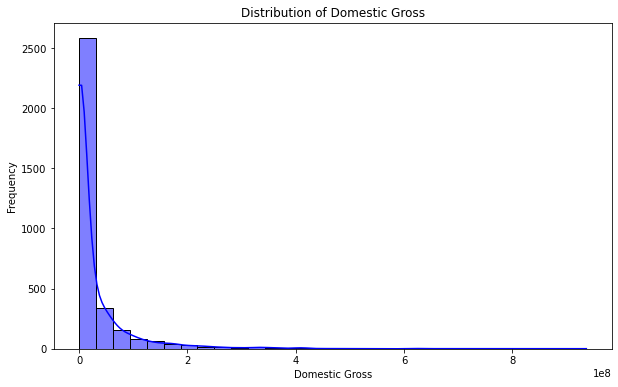

In [2401]:
data = box_office_mojo_df['domestic_gross']

# Plotting the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Domestic Gross')
plt.ylabel('Frequency')
plt.title('Distribution of Domestic Gross')

# Show plot
plt.show()


The graph isn't a normal distribution, the data is skewed to the right

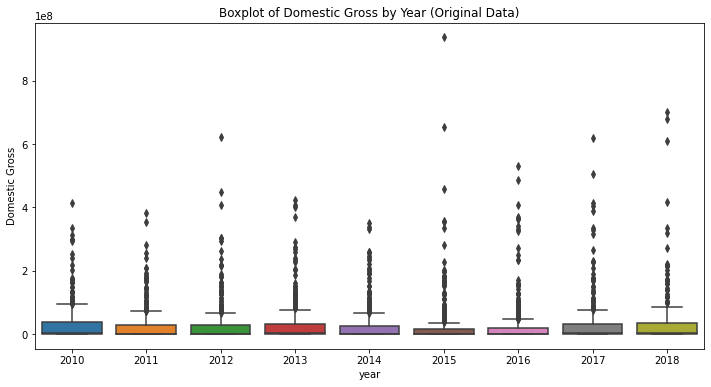

In [2402]:
# plot the outliers for domestic_gross and year using a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=box_office_mojo_df, x='year', y='domestic_gross')
plt.ylabel('Domestic Gross')
plt.title('Boxplot of Domestic Gross by Year (Original Data)')
plt.show()

As you can see from the data that there are a lot outliers in the data

In [2403]:
box_office_mojo_df

,title,studio,domestic_gross,year
0,Toy Story 3,BV,415000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,2010
3,Inception,WB,292600000.0,2010
4,Shrek Forever After,P/DW,238700000.0,2010
...,...,...,...,...
3382,The Quake,Magn.,6200.0,2018
3383,Edward II (2018 re-release),FM,4800.0,2018
3384,El Pacto,Sony,2500.0,2018
3385,The Swan,Synergetic,2400.0,2018


In [2404]:
box_office_mojo_df.describe()

,domestic_gross,year
count,3.376000e+03,3376.000000
mean,2.863480e+07,2013.960900
std,6.685139e+07,2.478759
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.300000e+06,2014.000000
75%,2.780000e+07,2016.000000
max,9.367000e+08,2018.000000


### Review:

We decided to keep these data points because these outliers represent natural variation in our dataset population (True Outliers). These points are not errors, they are the best grossing movies from 2014-2018. They should be kept to provide a variety of possible genres to recommend to out stakeholder.

This leaves us with a total of 1906 movies to examine later on

### imdb_movies_df

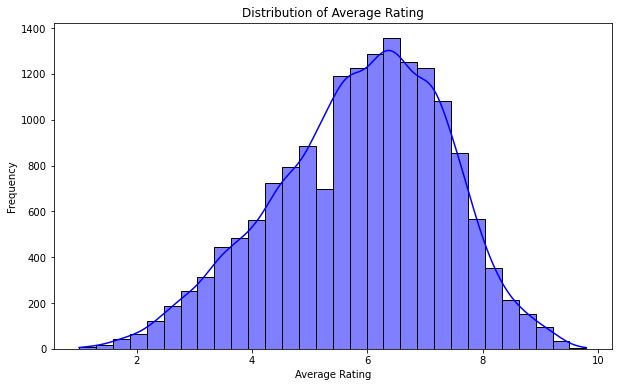

In [2405]:
# Example assuming 'domestic_gross' is a column in your DataFrame
data = imdb_movies_df['average_rating']

# Plotting the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Rating')

# Show plot
plt.show()

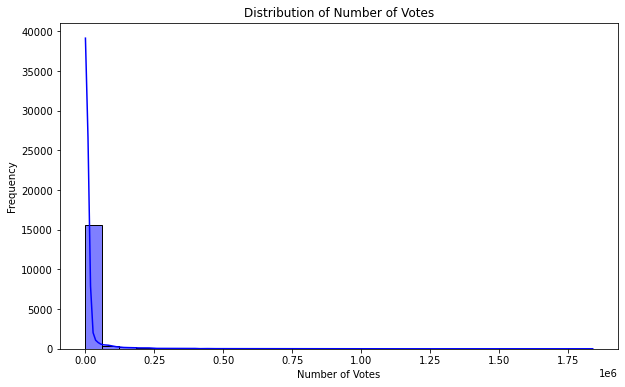

In [2406]:
# Example assuming 'domestic_gross' is a column in your DataFrame
data = imdb_movies_df['num_votes']

# Plotting the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Votes')

# Show plot
plt.show()

This graph is considered to be normally distributed

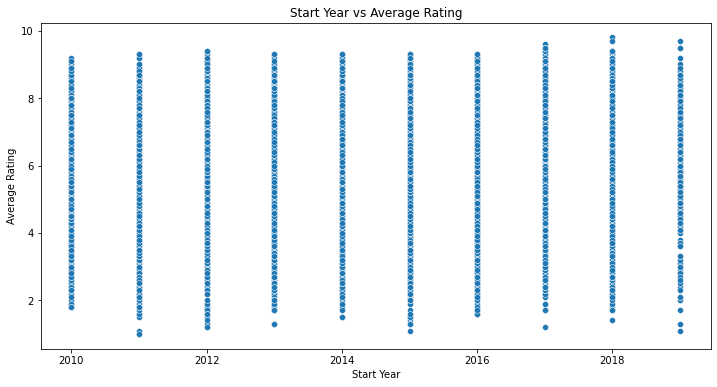

In [2407]:
# violin plot for start_year vs average_rating
plt.figure(figsize=(12, 6))
sns.scatterplot(data=imdb_movies_df, x='start_year', y='average_rating')
plt.xlabel('Start Year')
plt.ylabel('Average Rating')
plt.title('Start Year vs Average Rating')
plt.show()

In [2408]:
# detect outliers 
outliers = find_iqr_outliers(imdb_movies_df, 'average_rating')
outliers

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
396,Robin Hood: Ghosts of Sherwood,2012,116,1.7,468,"Action,Adventure,Mystery"
1248,Birdemic 2: The Resurrection,2013,90,1.7,3937,"Action,Comedy,Horror"
1431,Himmatwala,2013,150,1.7,7384,"Action,Comedy,Drama"
1665,The 6th Extinction,2012,90,1.7,277,Horror
1935,Rise of the Black Bat,2012,80,1.2,616,"Action,Sci-Fi"
2843,Captain Battle: Legacy War,2013,90,1.3,369,"Action,Sci-Fi,War"
3343,Futures Past,2012,120,1.3,33,"Action,Biography,History"
3816,Justin Bieber: Never Say Never,2011,105,1.6,74978,"Documentary,Music"
4735,Jurassic Shark,2012,75,1.6,3697,"Action,Adventure,Comedy"
6136,Kiara the Brave,2011,90,1.5,415,Animation


In [2409]:
# remove outliers
imdb_movies_df = remove_iqr_outliers(imdb_movies_df, 'average_rating')
imdb_movies_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
5,John Carter,2012,132,6.6,241792,"Action,Adventure,Sci-Fi"
9,Alice in Wonderland,2010,108,6.5,358813,"Adventure,Family,Fantasy"
12,Dark Buenos Aires,2010,90,3.4,123,Thriller
13,The Bourne Legacy,2012,135,6.7,268678,"Action,Adventure,Thriller"
...,...,...,...,...,...,...
30186,Devil's Tree: Rooted Evil,2018,76,4.9,1466,"Horror,Thriller"
30188,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"
30190,Coconut the Little Dragon 2 Into the Jungle,2018,Unknown,5.9,43,"Adventure,Animation,Comedy"
30192,Hail Satan?,2019,95,6.8,628,Documentary


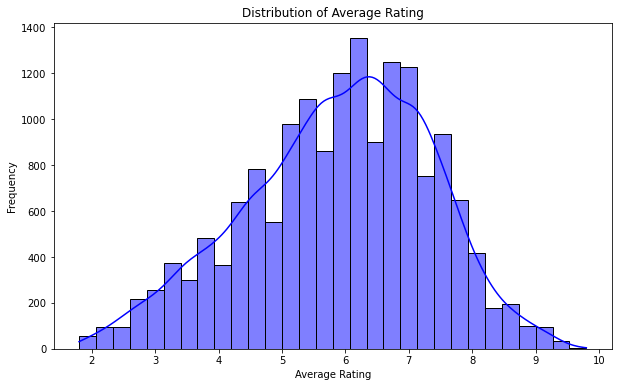

In [2410]:
data = imdb_movies_df['average_rating']

# Plotting the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Rating')

# Show plot
plt.show()

In [2411]:
# resets the index
imdb_movies_df.reset_index(drop=True, inplace=True)
imdb_movies_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
1,John Carter,2012,132,6.6,241792,"Action,Adventure,Sci-Fi"
2,Alice in Wonderland,2010,108,6.5,358813,"Adventure,Family,Fantasy"
3,Dark Buenos Aires,2010,90,3.4,123,Thriller
4,The Bourne Legacy,2012,135,6.7,268678,"Action,Adventure,Thriller"
...,...,...,...,...,...,...
16424,Devil's Tree: Rooted Evil,2018,76,4.9,1466,"Horror,Thriller"
16425,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"
16426,Coconut the Little Dragon 2 Into the Jungle,2018,Unknown,5.9,43,"Adventure,Animation,Comedy"
16427,Hail Satan?,2019,95,6.8,628,Documentary


In [2412]:
imdb_movies_df.describe()

,start_year,average_rating,num_votes
count,16429.000000,16429.000000,1.642900e+04
mean,2014.156796,5.882945,1.360481e+04
std,2.577814,1.465395,6.247570e+04
min,2010.000000,1.800000,3.100000e+01
25%,2012.000000,4.900000,8.400000e+01
50%,2014.000000,6.000000,2.960000e+02
75%,2016.000000,7.000000,1.798000e+03
max,2019.000000,9.800000,1.841066e+06


### Review:

We filtered out the outliers of ratings less than 2. This would provide a good reading to find better performing movies, but still include low rating movies to compare too. Looking at the average_rating and start_year we can see that in each year there are good rated movies and bad rated movies. This indicates that movies aren't necessary getting better as the years go on.

### imdb_people_df

In [2413]:
imdb_people_df

,primary_name,birth_year,category,primary_profession
0,Corey Large,1975.0,producer,"producer,actor,writer"
1,John Rickard,1977.0,producer,"producer,miscellaneous,actor"
2,Alexandre Vallès,1975.0,director,"actor,director,writer"
3,Gabriel Horn,1978.0,director,"actor,producer,writer"
4,Benoit Roland,1981.0,producer,"producer,production_manager,miscellaneous"
...,...,...,...,...
9226,Johnny Holiday,1977.0,director,"actor,director,producer"
9227,Zachary Stuart-Pontier,1983.0,producer,"editor,producer,miscellaneous"
9228,Lilly Engel,1974.0,director,"director,writer,actress"
9229,Tyson Moultrie,1987.0,producer,"producer,director,writer"


In [2414]:
imdb_people_df.describe()

,birth_year
count,9231.000000
mean,1980.998375
std,5.271759
min,1974.000000
25%,1977.000000
50%,1980.000000
75%,1984.000000
max,2007.000000


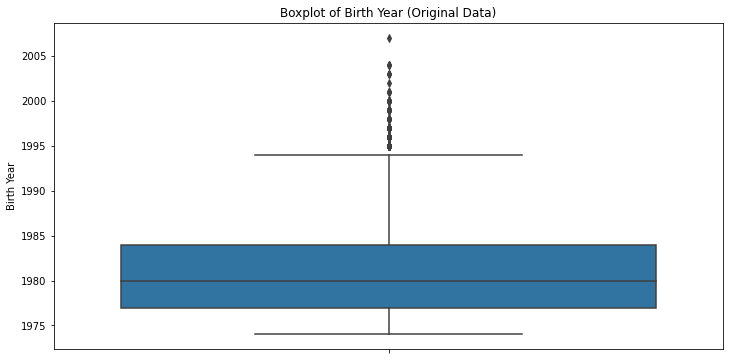

In [2415]:
# plot the outliers for birth_year using a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=imdb_people_df, y='birth_year')
plt.ylabel('Birth Year')
plt.title('Boxplot of Birth Year (Original Data)')
plt.show()

### Review

We are keeping all of the data in imdb_people_df, as it is a true representation of all people who were casted or a crew member. Keeping all of the data here would better represent the data, as it wouldn't make sense to drop anyone based on birth_year. For example: if a baby/small child was needed and we casted them out due to them being outliers, we wouldn't have any information on them.

### Numbers DB

In [2416]:
numbers_df

,release_date,movie,production_budget,domestic_gross,profit_loss
0,2009-12-18,Avatar,425000000.0,760507625.0,335507625.0
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,-169536125.0
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,-307237650.0
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,128405868.0
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,303181382.0
...,...,...,...,...,...
3858,2004-10-08,Primer,7000.0,424760.0,417760.0
3859,2006-05-26,Cavite,7000.0,70071.0,63071.0
3860,2004-12-31,The Mongol King,7000.0,900.0,-6100.0
3861,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,-3662.0


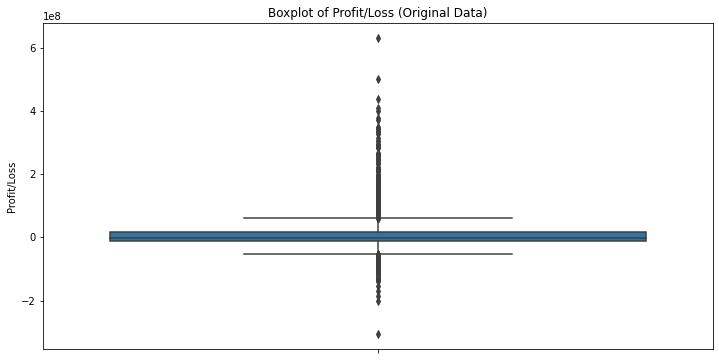

In [2417]:
# graph the outliers for profit/loss using a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=numbers_df, y='profit_loss')
plt.ylabel('Profit/Loss')
plt.title('Boxplot of Profit/Loss (Original Data)')
plt.show()

### Review

We decided to keep all of this data, because it represents "true outliers". We don't want to get rid of the best movies that profited the most.

### The Movies DB

In [2418]:
movie_db_df.columns

Index(['original_title', 'popularity', 'release_date', 'title', 'vote_average',
       'vote_count', 'genres'],
      dtype='object')

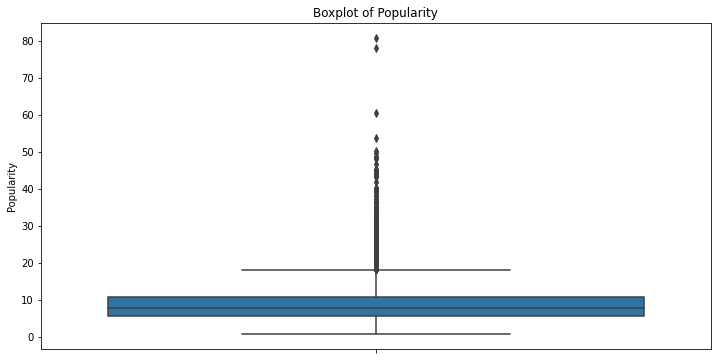

In [2419]:
# graph the outliers for popularity using a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=movie_db_df, y='popularity')
plt.ylabel('Popularity')
plt.title('Boxplot of Popularity')
plt.show()

### Review

We decided to keep all of these data points and not filter them out because they represent "true outliers". We want to compare all of the data together to get the best result.

### Filtered and Cleaned Datasets

In [2420]:
box_office_mojo_df

,title,studio,domestic_gross,year
0,Toy Story 3,BV,415000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,2010
3,Inception,WB,292600000.0,2010
4,Shrek Forever After,P/DW,238700000.0,2010
...,...,...,...,...
3382,The Quake,Magn.,6200.0,2018
3383,Edward II (2018 re-release),FM,4800.0,2018
3384,El Pacto,Sony,2500.0,2018
3385,The Swan,Synergetic,2400.0,2018


In [2421]:
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3376 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3376 non-null   object 
 1   studio          3376 non-null   object 
 2   domestic_gross  3376 non-null   float64
 3   year            3376 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 291.9+ KB


In [2422]:
box_office_mojo_df.describe()

,domestic_gross,year
count,3.376000e+03,3376.000000
mean,2.863480e+07,2013.960900
std,6.685139e+07,2.478759
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.300000e+06,2014.000000
75%,2.780000e+07,2016.000000
max,9.367000e+08,2018.000000


In [2423]:
imdb_movies_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
1,John Carter,2012,132,6.6,241792,"Action,Adventure,Sci-Fi"
2,Alice in Wonderland,2010,108,6.5,358813,"Adventure,Family,Fantasy"
3,Dark Buenos Aires,2010,90,3.4,123,Thriller
4,The Bourne Legacy,2012,135,6.7,268678,"Action,Adventure,Thriller"
...,...,...,...,...,...,...
16424,Devil's Tree: Rooted Evil,2018,76,4.9,1466,"Horror,Thriller"
16425,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"
16426,Coconut the Little Dragon 2 Into the Jungle,2018,Unknown,5.9,43,"Adventure,Animation,Comedy"
16427,Hail Satan?,2019,95,6.8,628,Documentary


In [2424]:
imdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16429 entries, 0 to 16428
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    16429 non-null  object 
 1   start_year       16429 non-null  int64  
 2   runtime_minutes  16429 non-null  object 
 3   average_rating   16429 non-null  float64
 4   num_votes        16429 non-null  int64  
 5   genres           16429 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 770.2+ KB


In [2425]:
imdb_movies_df.describe()

,start_year,average_rating,num_votes
count,16429.000000,16429.000000,1.642900e+04
mean,2014.156796,5.882945,1.360481e+04
std,2.577814,1.465395,6.247570e+04
min,2010.000000,1.800000,3.100000e+01
25%,2012.000000,4.900000,8.400000e+01
50%,2014.000000,6.000000,2.960000e+02
75%,2016.000000,7.000000,1.798000e+03
max,2019.000000,9.800000,1.841066e+06


In [2426]:
imdb_people_df

,primary_name,birth_year,category,primary_profession
0,Corey Large,1975.0,producer,"producer,actor,writer"
1,John Rickard,1977.0,producer,"producer,miscellaneous,actor"
2,Alexandre Vallès,1975.0,director,"actor,director,writer"
3,Gabriel Horn,1978.0,director,"actor,producer,writer"
4,Benoit Roland,1981.0,producer,"producer,production_manager,miscellaneous"
...,...,...,...,...
9226,Johnny Holiday,1977.0,director,"actor,director,producer"
9227,Zachary Stuart-Pontier,1983.0,producer,"editor,producer,miscellaneous"
9228,Lilly Engel,1974.0,director,"director,writer,actress"
9229,Tyson Moultrie,1987.0,producer,"producer,director,writer"


In [2427]:
imdb_people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9231 entries, 0 to 9230
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   primary_name        9231 non-null   object 
 1   birth_year          9231 non-null   float64
 2   category            9231 non-null   object 
 3   primary_profession  9231 non-null   object 
dtypes: float64(1), object(3)
memory usage: 288.6+ KB


In [2428]:
imdb_people_df.describe()

,birth_year
count,9231.000000
mean,1980.998375
std,5.271759
min,1974.000000
25%,1977.000000
50%,1980.000000
75%,1984.000000
max,2007.000000


In [2429]:
numbers_df

,release_date,movie,production_budget,domestic_gross,profit_loss
0,2009-12-18,Avatar,425000000.0,760507625.0,335507625.0
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,-169536125.0
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,-307237650.0
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,128405868.0
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,303181382.0
...,...,...,...,...,...
3858,2004-10-08,Primer,7000.0,424760.0,417760.0
3859,2006-05-26,Cavite,7000.0,70071.0,63071.0
3860,2004-12-31,The Mongol King,7000.0,900.0,-6100.0
3861,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,-3662.0


In [2430]:
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3863 entries, 0 to 3862
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       3863 non-null   datetime64[ns]
 1   movie              3863 non-null   object        
 2   production_budget  3863 non-null   float64       
 3   domestic_gross     3863 non-null   float64       
 4   profit_loss        3863 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 151.0+ KB


In [2431]:
numbers_df.describe()

,production_budget,domestic_gross,profit_loss
count,3.863000e+03,3.863000e+03,3.863000e+03
mean,3.803566e+07,4.748882e+07,9.453165e+06
std,4.708862e+07,7.415705e+07,5.164515e+07
min,1.100000e+03,3.880000e+02,-3.072376e+08
25%,7.750000e+06,3.160708e+06,-1.051224e+07
50%,2.000000e+07,2.147168e+07,-5.408890e+05
75%,5.000000e+07,5.836636e+07,1.843035e+07
max,4.250000e+08,9.366622e+08,6.306622e+08


In [2432]:
movie_db_df

,original_title,popularity,release_date,title,vote_average,vote_count,genres
0,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure, Family, Fantasy"
1,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Adventure, Animation, Family, Fantasy"
2,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Action, Adventure, Science Fiction"
3,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Adventure, Science Fiction"
4,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,"Adventure, Family, Fantasy"
...,...,...,...,...,...,...,...
5203,Adventures in Public School,3.026,2018-02-07,Adventures in Public School,5.7,36,Comedy
5204,Feminists: What Were They Thinking?,2.871,2018-02-19,Feminists: What Were They Thinking?,8.2,42,Documentary
5205,Bilal: A New Breed of Hero,2.707,2018-02-02,Bilal: A New Breed of Hero,6.8,54,"Action, Adventure, Animation"
5206,The Devil and Father Amorth,1.850,2018-04-20,The Devil and Father Amorth,5.3,40,"Documentary, Horror"


In [2433]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5208 entries, 0 to 5207
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   original_title  5208 non-null   object        
 1   popularity      5208 non-null   float64       
 2   release_date    5208 non-null   datetime64[ns]
 3   title           5208 non-null   object        
 4   vote_average    5208 non-null   float64       
 5   vote_count      5208 non-null   int64         
 6   genres          5208 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 284.9+ KB


In [2434]:
movie_db_df.describe()

,popularity,vote_average,vote_count
count,5208.000000,5208.000000,5208.000000
mean,9.044014,6.134793,890.092166
std,6.072036,0.976438,1967.959476
min,0.600000,1.600000,31.000000
25%,5.664750,5.500000,58.000000
50%,7.636000,6.100000,154.000000
75%,10.672000,6.800000,683.250000
max,80.773000,8.900000,22186.000000


### Correlation Analysis

In [2435]:
# function for finding the scatter plot between two columns
def scatter_plot(df, x, y):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x=x, y=y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{x} vs {y}')
    plt.show()

# function for finding the correlation matrix
def correlation_matrix(df):
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

### Box Office Mojo

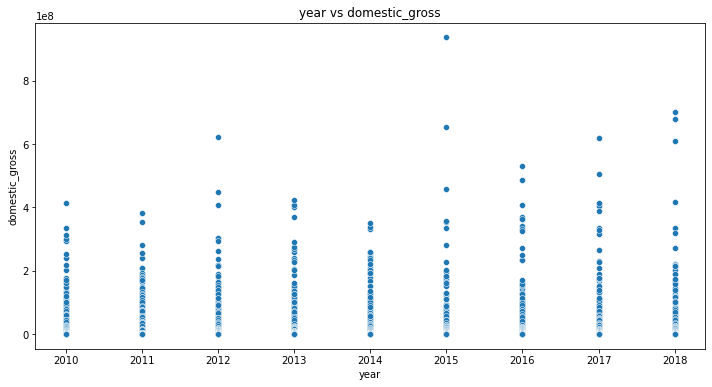

In [2436]:
# scatter plot for year vs domestic_gross
scatter_plot(box_office_mojo_df, 'year', 'domestic_gross')

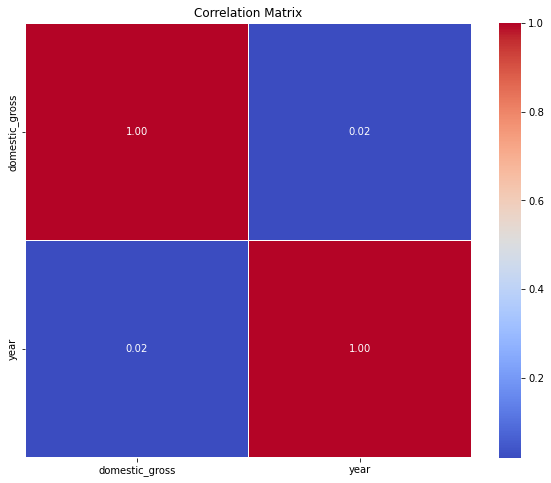

In [2437]:
# correlation matrix for box_office_mojo_df
correlation_matrix(box_office_mojo_df)

In [2438]:
# perform chi-square test for year and studio columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(box_office_mojo_df['year'], box_office_mojo_df['studio']))
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")


Chi-square value: 3146.537897752055
P-value: 1.9277989059427703e-51
Degrees of freedom: 2032
Expected frequencies: [[0.09686019 0.19372038 4.74614929 ... 1.35604265 0.09686019 1.54976303]
 [0.11759479 0.23518957 5.76214455 ... 1.64632701 0.11759479 1.88151659]
 [0.117891   0.23578199 5.77665877 ... 1.65047393 0.117891   1.88625592]
 ...
 [0.12885071 0.25770142 6.31368483 ... 1.80390995 0.12885071 2.06161137]
 [0.09478673 0.18957346 4.64454976 ... 1.32701422 0.09478673 1.51658768]
 [0.09123223 0.18246445 4.47037915 ... 1.27725118 0.09123223 1.45971564]]


### IMDB Movies

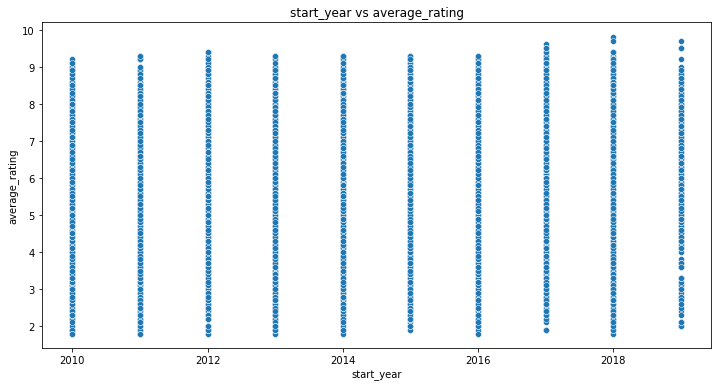

In [2439]:
# scatter plot for start_year vs average_rating
scatter_plot(imdb_movies_df, 'start_year', 'average_rating')

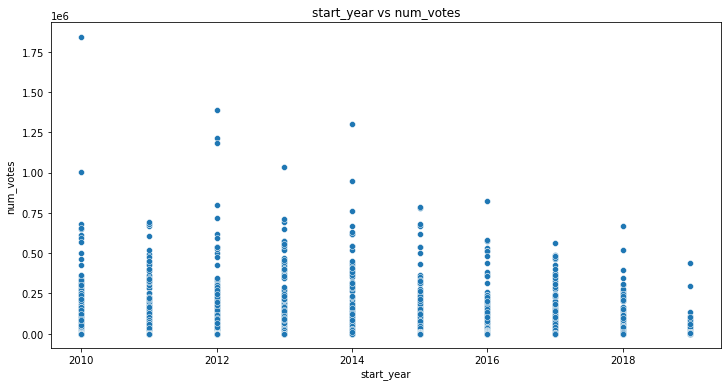

In [2440]:
# scatter plot for start_year vs num_votes
scatter_plot(imdb_movies_df, 'start_year', 'num_votes')

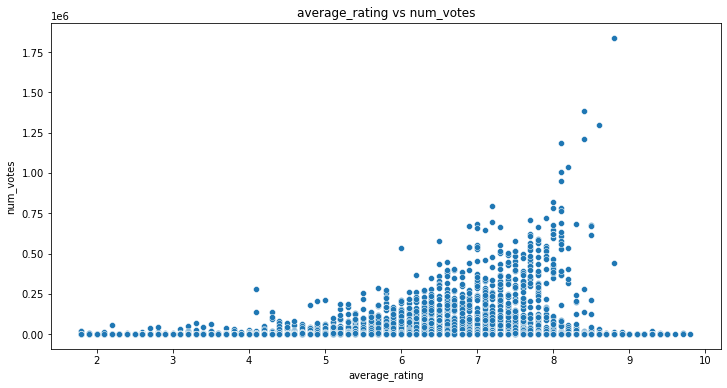

In [2441]:
# scatter plot for average_rating vs num_votes
scatter_plot(imdb_movies_df, 'average_rating', 'num_votes')

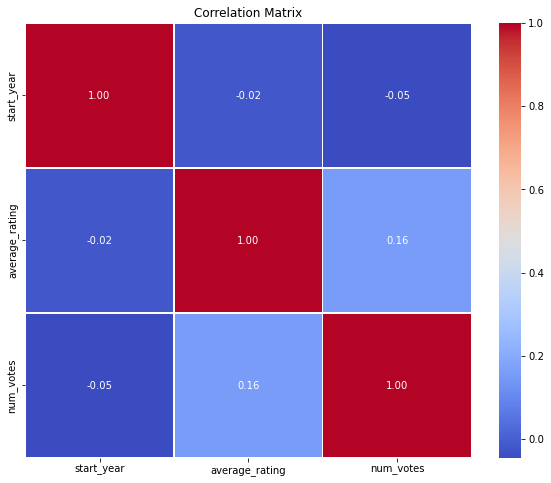

In [2442]:
# correlation matrix for imdb_movies_df
correlation_matrix(imdb_movies_df)

### IMDB People

In [2443]:
# perform chi-square test for category and primary_profession columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(imdb_people_df['category'], imdb_people_df['primary_profession']))
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

Chi-square value: 4904.943593017115
P-value: 0.0
Degrees of freedom: 1297
Expected frequencies: [[2.67966634 0.66991659 0.66991659 ... 0.66991659 0.66991659 0.66991659]
 [1.32033366 0.33008341 0.33008341 ... 0.33008341 0.33008341 0.33008341]]


### Numbers

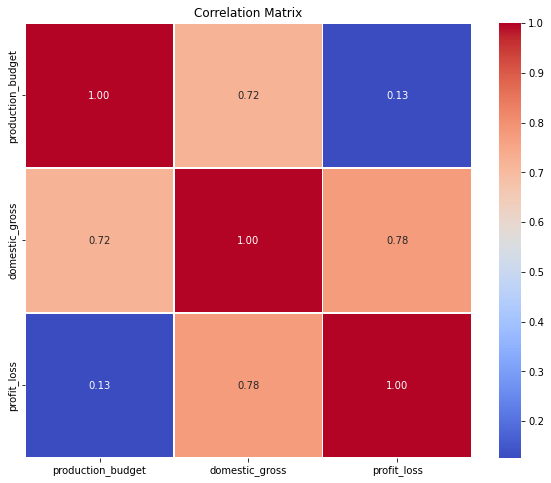

In [2444]:
# correlation matrix for numbers_df
correlation_matrix(numbers_df)

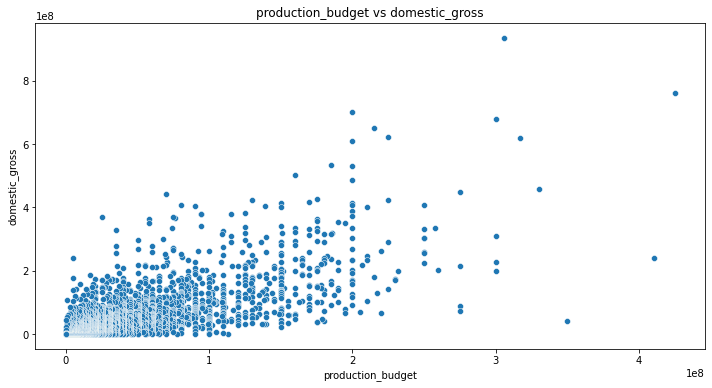

In [2445]:
# scatter plot for production_budget vs profit_loss
scatter_plot(numbers_df, 'production_budget', 'domestic_gross')

### The Movies

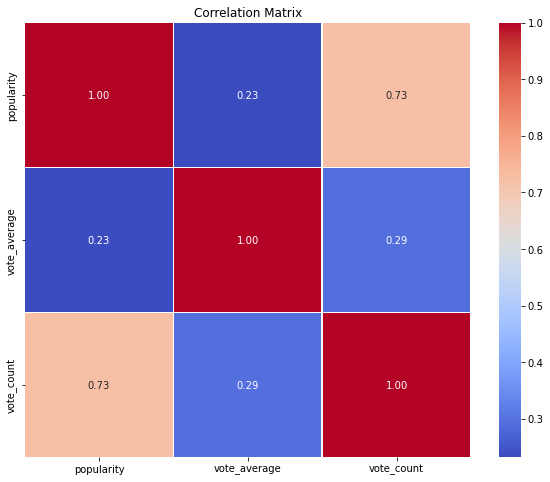

In [2446]:
# correlation matrix for movie_db_df
correlation_matrix(movie_db_df)

In [2447]:
# perform chi-square test for genres and popularity columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(movie_db_df['genres'], movie_db_df['popularity']))

# print the results
print(f"Chi-square: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected: ")
print(expected)

Chi-square: 2870144.002464675
P-value: 0.0
Degrees of Freedom: 2623406
Expected: 
[[0.01056068 0.00096006 0.00096006 ... 0.00096006 0.00096006 0.00096006]
 [0.08659754 0.0078725  0.0078725  ... 0.0078725  0.0078725  0.0078725 ]
 [0.02534562 0.00230415 0.00230415 ... 0.00230415 0.00230415 0.00230415]
 ...
 [0.00211214 0.00019201 0.00019201 ... 0.00019201 0.00019201 0.00019201]
 [0.00211214 0.00019201 0.00019201 ... 0.00019201 0.00019201 0.00019201]
 [0.00844854 0.00076805 0.00076805 ... 0.00076805 0.00076805 0.00076805]]


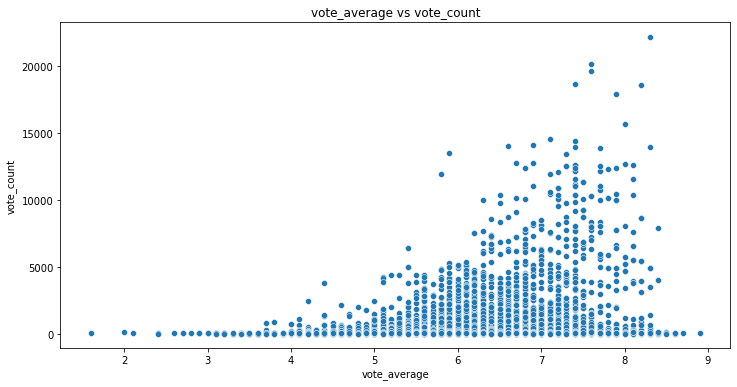

In [2448]:
# graph for vote_count and vote_average
scatter_plot(movie_db_df, 'vote_average', 'vote_count')

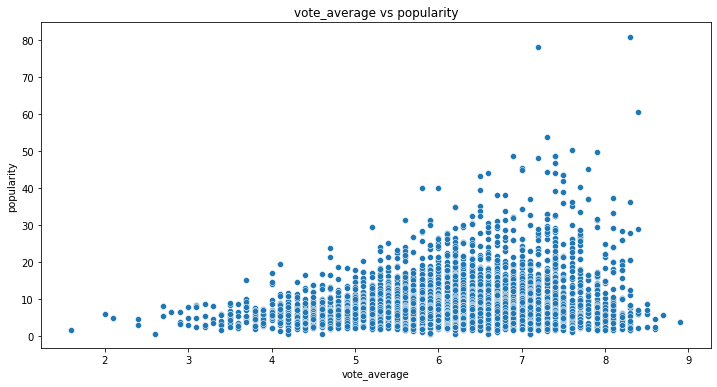

In [2449]:
# graph for popularity and vote_average
scatter_plot(movie_db_df, 'vote_average', 'popularity')

In [2450]:
movie_db_df.head()

,original_title,popularity,release_date,title,vote_average,vote_count,genres
0,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure, Family, Fantasy"
1,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Adventure, Animation, Family, Fantasy"
2,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Action, Adventure, Science Fiction"
3,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Adventure, Science Fiction"
4,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,"Adventure, Family, Fantasy"


## Feature Engineering

### Box Office Mojo

In [2451]:
box_office_mojo_df

,title,studio,domestic_gross,year
0,Toy Story 3,BV,415000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,2010
3,Inception,WB,292600000.0,2010
4,Shrek Forever After,P/DW,238700000.0,2010
...,...,...,...,...
3382,The Quake,Magn.,6200.0,2018
3383,Edward II (2018 re-release),FM,4800.0,2018
3384,El Pacto,Sony,2500.0,2018
3385,The Swan,Synergetic,2400.0,2018


In [2452]:
# find the gross for each studio into a new dataframe
studio_gross_df = box_office_mojo_df.groupby('studio')['domestic_gross'].sum().sort_values(ascending=False).reset_index()
studio_gross_df.head()

,studio,domestic_gross
0,BV,1.841903e+10
1,Uni.,1.290239e+10
2,WB,1.210435e+10
3,Fox,1.094950e+10
4,Sony,8.561750e+09


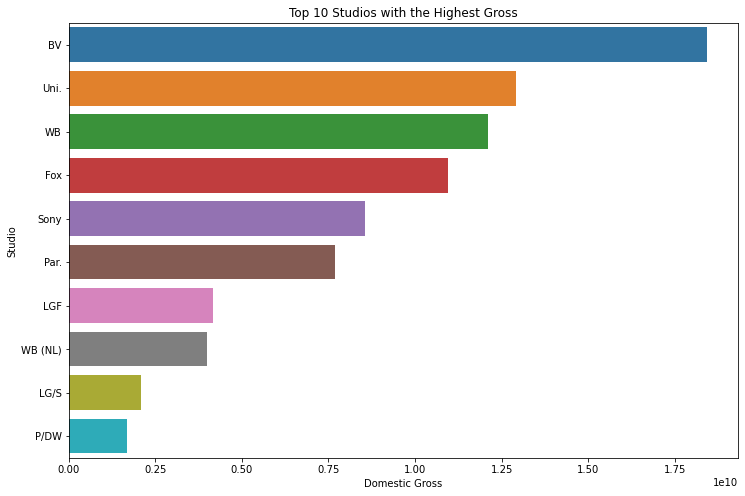

In [2453]:
# graphs the top 10 studios with the highest gross
plt.figure(figsize=(12, 8))
sns.barplot(x='domestic_gross', y='studio', data=studio_gross_df.head(10))
plt.title('Top 10 Studios with the Highest Gross')
plt.xlabel('Domestic Gross')
plt.ylabel('Studio')
plt.show()

In [2454]:
# find the gross for each studio in each year into a new dataframe
studio_year_gross_df = box_office_mojo_df.groupby(['studio', 'year'])['domestic_gross'].sum().sort_values(ascending=False).reset_index()
studio_year_gross_df

,studio,year,domestic_gross
0,BV,2018,3.045600e+09
1,BV,2016,2.871000e+09
2,BV,2015,2.495700e+09
3,Uni.,2015,2.429738e+09
4,BV,2017,2.378200e+09
...,...,...,...
732,Grav.,2018,1.700000e+03
733,Vita.,2013,1.100000e+03
734,DR,2014,8.000000e+02
735,BWP,2015,7.000000e+02


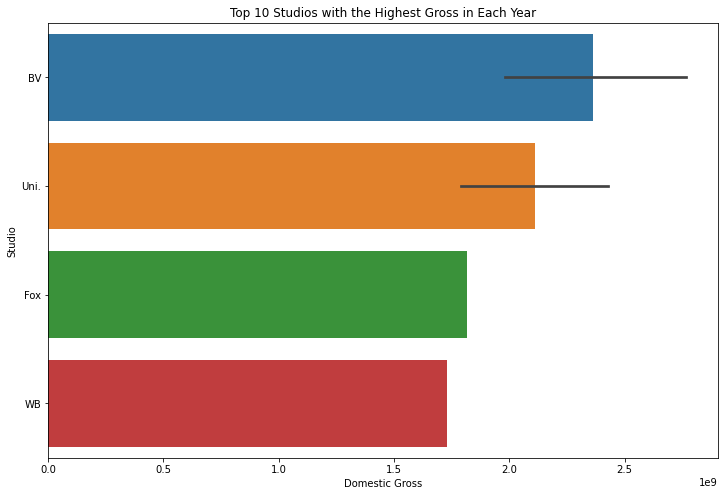

In [2455]:
# graphs the top 10 studios with the highest gross in each year
plt.figure(figsize=(12, 8))
sns.barplot(x='domestic_gross', y='studio', data=studio_year_gross_df.head(10))
plt.title('Top 10 Studios with the Highest Gross in Each Year')
plt.xlabel('Domestic Gross')
plt.ylabel('Studio')
plt.show()

In [2456]:
# create a copy of the dataframe
temp_imdb_movies_df = imdb_movies_df.copy()

# seperate the genres into new columns
temp_imdb_movies_df['genres'] = imdb_movies_df['genres'].str.split(',')

In [2457]:
# explode the genres column
imdb_movies_seperate_genres_df = temp_imdb_movies_df.explode('genres')

imdb_movies_seperate_genres_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124,7.0,539338,Action
0,Jurassic World,2015,124,7.0,539338,Adventure
0,Jurassic World,2015,124,7.0,539338,Sci-Fi
1,John Carter,2012,132,6.6,241792,Action
1,John Carter,2012,132,6.6,241792,Adventure
...,...,...,...,...,...,...
16426,Coconut the Little Dragon 2 Into the Jungle,2018,Unknown,5.9,43,Animation
16426,Coconut the Little Dragon 2 Into the Jungle,2018,Unknown,5.9,43,Comedy
16427,Hail Satan?,2019,95,6.8,628,Documentary
16428,Alien Warfare,2019,88,2.6,1509,Action


In [2458]:
# get the unique genres
unique_genres = imdb_movies_seperate_genres_df['genres'].unique()
unique_genres

array(['Action', 'Adventure', 'Sci-Fi', 'Family', 'Fantasy', 'Thriller',
       'Comedy', 'Crime', 'Mystery', 'Documentary', 'Drama', 'Musical',
       'Romance', 'Animation', 'Horror', 'Music', 'Sport', 'Biography',
       'Western', 'History', 'War', 'News', 'Reality-TV', 'Game-Show',
       'Adult'], dtype=object)

In [2459]:
# find the best genre based on the average rating
best_genre = imdb_movies_seperate_genres_df.groupby('genres')['average_rating'].mean().sort_values(ascending=False).reset_index()
best_genre

,genres,average_rating
0,News,7.207031
1,Documentary,7.161521
2,Biography,7.000319
3,History,6.906914
4,Music,6.902479
5,Sport,6.733333
6,War,6.194675
7,Musical,6.176378
8,Animation,6.093347
9,Drama,6.087334


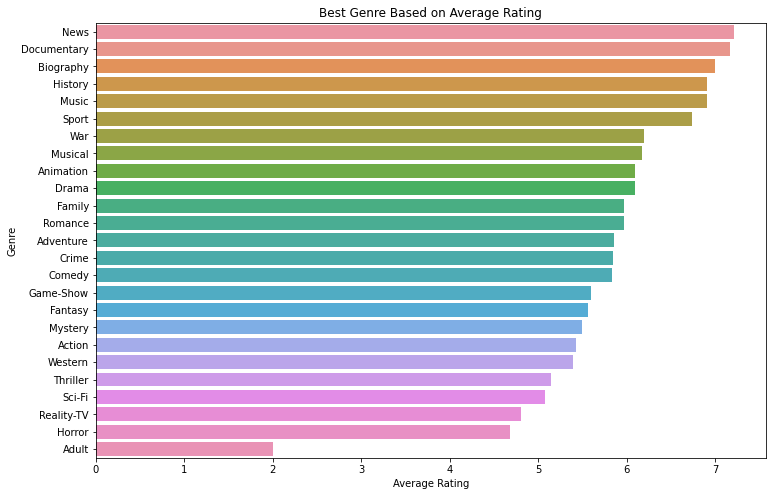

In [2460]:
# graph the best genre based on the average rating
plt.figure(figsize=(12, 8))
sns.barplot(x='average_rating', y='genres', data=best_genre)
plt.title('Best Genre Based on Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

In [2461]:
# find the total number of movies for each genre
genre_count = imdb_movies_seperate_genres_df['genres'].value_counts().reset_index()
genre_count

,index,genres
0,Drama,6711
1,Comedy,4228
2,Documentary,3051
3,Horror,3034
4,Thriller,2825
5,Action,2188
6,Romance,1547
7,Crime,1449
8,Adventure,1295
9,Mystery,970


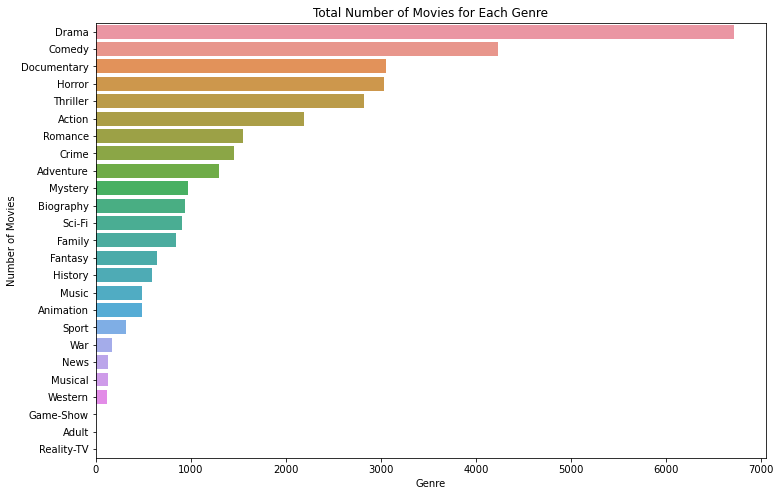

In [2462]:
# graph the total number of movies for each genre
plt.figure(figsize=(12, 8))
sns.barplot(x='genres', y='index', data=genre_count)
plt.title('Total Number of Movies for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()

In [2463]:
# find the best genre based on the average_rating and the total number of movies for each genre
genre_count = genre_count.rename(columns={'index': 'genre', 'genres': 'count'})
genre_count = genre_count.merge(best_genre, left_on='genre', right_on='genres')

# sort the dataframe by the average_rating
genre_count = genre_count.sort_values(by='average_rating', ascending=False)

# drop the genres column
genre_count.drop(columns=['genre'], inplace=True)

genre_count

,count,genres,average_rating
19,128,News,7.207031
2,3051,Documentary,7.161521
10,939,Biography,7.000319
14,593,History,6.906914
15,484,Music,6.902479
17,312,Sport,6.733333
18,169,War,6.194675
20,127,Musical,6.176378
16,481,Animation,6.093347
0,6711,Drama,6.087334


### Review

From these graphs we can see that the top 10 highest rated genres are: 

1.  Reality-TV	
2.	Documentary	
3.	News	
4.	Biography	
5.	History	
6.	Music	
7.	Sport	
8.	Musical	
9.	War	
10.	Drama	

The most common genres of movies are:

1.  Drama
2.	Comedy
3.	Documentary
4.	Horror
5.	Thriller
6.	Action
7.	Romance
8.	Crime
9.	Adventure
10.	Biography


In [2464]:
# find matching movies in both dataframes
matching_movies = box_office_mojo_df[box_office_mojo_df['title'].isin(imdb_movies_df['primary_title'])]

# include the domestic_gross column from box_office_mojo_df
matching_movies = matching_movies.merge(imdb_movies_df, left_on='title', right_on='primary_title', how='inner')

matching_movies

,title,studio,domestic_gross,year,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Toy Story 3,BV,415000000.0,2010,Toy Story 3,2010,103,8.3,682218,"Adventure,Animation,Comedy"
1,Inception,WB,292600000.0,2010,Inception,2010,148,8.8,1841066,"Action,Adventure,Sci-Fi"
2,Shrek Forever After,P/DW,238700000.0,2010,Shrek Forever After,2010,93,6.3,167532,"Adventure,Animation,Comedy"
3,The Twilight Saga: Eclipse,Sum.,300500000.0,2010,The Twilight Saga: Eclipse,2010,124,5.0,211733,"Adventure,Drama,Fantasy"
4,Iron Man 2,Par.,312400000.0,2010,Iron Man 2,2010,124,7.0,657690,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...,...,...,...,...
1772,What Will People Say,KL,44200.0,2018,What Will People Say,2017,106,7.5,3040,Drama
1773,Girls vs Gangsters,WGUSA,37100.0,2018,Girls vs Gangsters,2018,120,3.3,148,"Comedy,Drama"
1774,Loving Pablo,Uni.,22000.0,2018,Loving Pablo,2017,123,6.3,13988,"Action,Biography,Crime"
1775,Let Yourself Go,Men.,12200.0,2018,Let Yourself Go,2017,99,6.1,749,Comedy


In [2465]:
# seperate the genres into new columns and divide gross earnings if there are multiple genres. if only one genre, keep the same value
matching_movies['genres'] = matching_movies['genres'].str.split(',')
exploded_matching_movies = matching_movies.explode('genres')

In [2466]:
# drop primary_title, start_year column
exploded_matching_movies.drop(columns=['primary_title', 'start_year'], inplace=True)

In [2467]:
# Count the number of duplicates for each unique movie (based on title, studio, year)
exploded_matching_movies['duplicate_count'] = exploded_matching_movies.groupby(['title', 'studio', 'year'])['title'].transform('count')

# Divide the domestic_gross by the number of duplicates
exploded_matching_movies['adjusted_gross'] = exploded_matching_movies['domestic_gross'] / exploded_matching_movies['duplicate_count']

exploded_matching_movies

,title,studio,domestic_gross,year,runtime_minutes,average_rating,num_votes,genres,duplicate_count,adjusted_gross
0,Toy Story 3,BV,415000000.0,2010,103,8.3,682218,Adventure,3,1.383333e+08
0,Toy Story 3,BV,415000000.0,2010,103,8.3,682218,Animation,3,1.383333e+08
0,Toy Story 3,BV,415000000.0,2010,103,8.3,682218,Comedy,3,1.383333e+08
1,Inception,WB,292600000.0,2010,148,8.8,1841066,Action,3,9.753333e+07
1,Inception,WB,292600000.0,2010,148,8.8,1841066,Adventure,3,9.753333e+07
...,...,...,...,...,...,...,...,...,...,...
1774,Loving Pablo,Uni.,22000.0,2018,123,6.3,13988,Action,3,7.333333e+03
1774,Loving Pablo,Uni.,22000.0,2018,123,6.3,13988,Biography,3,7.333333e+03
1774,Loving Pablo,Uni.,22000.0,2018,123,6.3,13988,Crime,3,7.333333e+03
1775,Let Yourself Go,Men.,12200.0,2018,99,6.1,749,Comedy,1,1.220000e+04


In [2468]:
# find the total gross for each genre
genre_gross = exploded_matching_movies.groupby('genres')['adjusted_gross'].sum().sort_values(ascending=False).reset_index()
genre_gross

,genres,adjusted_gross
0,Adventure,1.365927e+10
1,Action,1.225647e+10
2,Comedy,1.203001e+10
3,Drama,8.751094e+09
4,Sci-Fi,4.772892e+09
5,Thriller,4.333977e+09
6,Animation,4.240851e+09
7,Fantasy,2.969083e+09
8,Crime,2.879083e+09
9,Romance,2.372575e+09


In [2469]:
df_combined = pd.merge(genre_gross, genre_count, on='genres', how='inner')

# Sort by adjusted gross and average rating
df_combined_sorted = df_combined.sort_values(by=['adjusted_gross', 'average_rating'], ascending=[False, False])

df_combined_sorted

,genres,adjusted_gross,count,average_rating
0,Adventure,1.365927e+10,1295,5.852664
1,Action,1.225647e+10,2188,5.422258
2,Comedy,1.203001e+10,4228,5.829376
3,Drama,8.751094e+09,6711,6.087334
4,Sci-Fi,4.772892e+09,903,5.071539
5,Thriller,4.333977e+09,2825,5.145310
6,Animation,4.240851e+09,481,6.093347
7,Fantasy,2.969083e+09,646,5.563467
8,Crime,2.879083e+09,1449,5.843202
9,Romance,2.372575e+09,1547,5.963219


In [2470]:
box_office_mojo_df

,title,studio,domestic_gross,year
0,Toy Story 3,BV,415000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,2010
3,Inception,WB,292600000.0,2010
4,Shrek Forever After,P/DW,238700000.0,2010
...,...,...,...,...
3382,The Quake,Magn.,6200.0,2018
3383,Edward II (2018 re-release),FM,4800.0,2018
3384,El Pacto,Sony,2500.0,2018
3385,The Swan,Synergetic,2400.0,2018


In [2471]:
imdb_movies_df 

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
1,John Carter,2012,132,6.6,241792,"Action,Adventure,Sci-Fi"
2,Alice in Wonderland,2010,108,6.5,358813,"Adventure,Family,Fantasy"
3,Dark Buenos Aires,2010,90,3.4,123,Thriller
4,The Bourne Legacy,2012,135,6.7,268678,"Action,Adventure,Thriller"
...,...,...,...,...,...,...
16424,Devil's Tree: Rooted Evil,2018,76,4.9,1466,"Horror,Thriller"
16425,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"
16426,Coconut the Little Dragon 2 Into the Jungle,2018,Unknown,5.9,43,"Adventure,Animation,Comedy"
16427,Hail Satan?,2019,95,6.8,628,Documentary


In [2472]:
numbers_df

,release_date,movie,production_budget,domestic_gross,profit_loss
0,2009-12-18,Avatar,425000000.0,760507625.0,335507625.0
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,-169536125.0
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,-307237650.0
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,128405868.0
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,303181382.0
...,...,...,...,...,...
3858,2004-10-08,Primer,7000.0,424760.0,417760.0
3859,2006-05-26,Cavite,7000.0,70071.0,63071.0
3860,2004-12-31,The Mongol King,7000.0,900.0,-6100.0
3861,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,-3662.0


In [2473]:
movie_db_df

,original_title,popularity,release_date,title,vote_average,vote_count,genres
0,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure, Family, Fantasy"
1,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Adventure, Animation, Family, Fantasy"
2,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Action, Adventure, Science Fiction"
3,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Adventure, Science Fiction"
4,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,"Adventure, Family, Fantasy"
...,...,...,...,...,...,...,...
5203,Adventures in Public School,3.026,2018-02-07,Adventures in Public School,5.7,36,Comedy
5204,Feminists: What Were They Thinking?,2.871,2018-02-19,Feminists: What Were They Thinking?,8.2,42,Documentary
5205,Bilal: A New Breed of Hero,2.707,2018-02-02,Bilal: A New Breed of Hero,6.8,54,"Action, Adventure, Animation"
5206,The Devil and Father Amorth,1.850,2018-04-20,The Devil and Father Amorth,5.3,40,"Documentary, Horror"
